In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, BatchNormalization, Activation, Add, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

11490434/11490434 [==============================] - 0s 0us/step


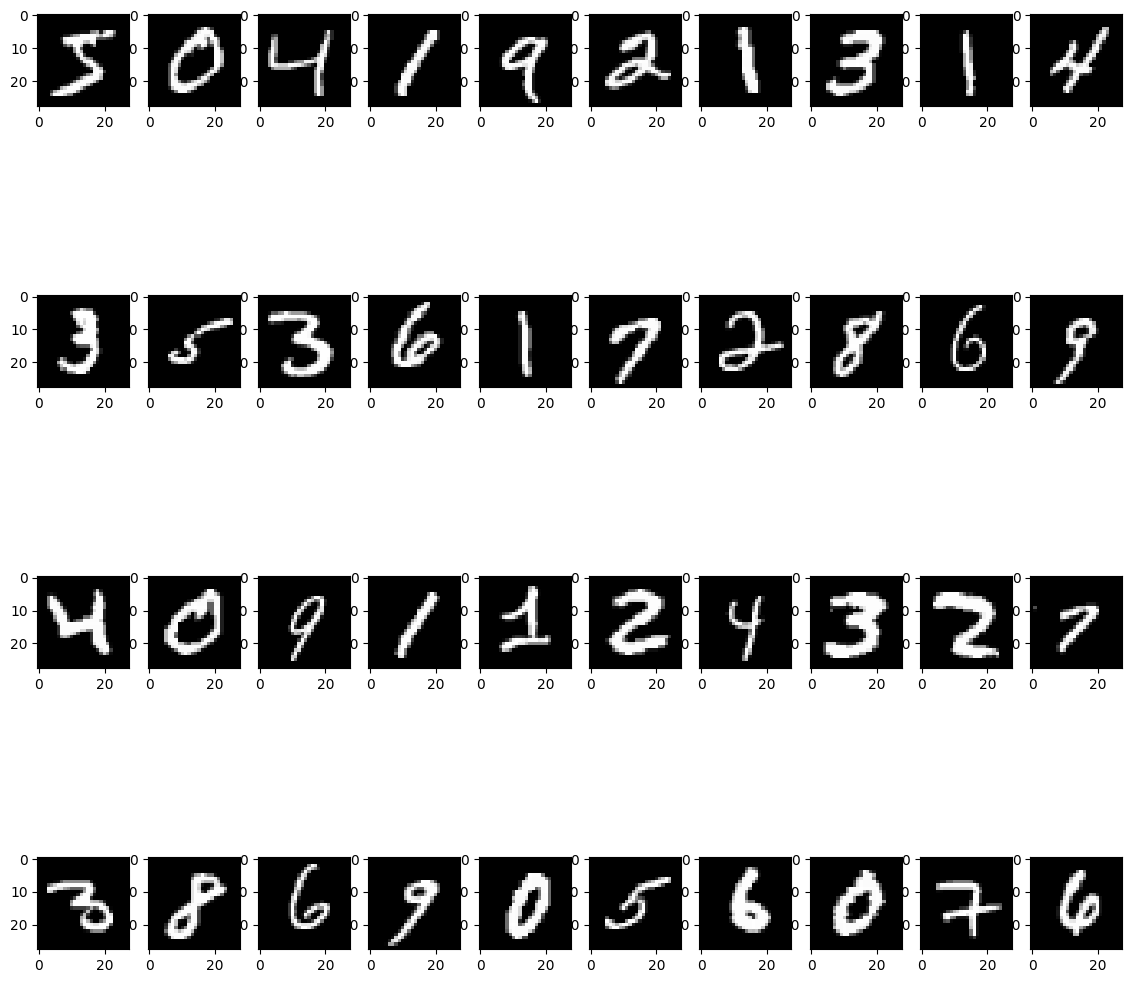

In [2]:
# MNIST veri setinin yüklenmesi
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Veri görselleştirme
plt.figure(figsize=(14,14))
x, y = 10, 4
for i in range(40):
    plt.subplot(y, x, i+1)
    plt.imshow(x_train[i], cmap='gray')
plt.show()

In [3]:
# Veri ön işleme
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32') / 255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32') / 255

# Sınıf vektörlerini kategorik hale getirme
y_train = to_categorical(y_train, 10)
y_test = to_categorical(y_test, 10)

In [4]:
# resnet
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=True):
    """
    Residual block için fonksiyon.
    """
    shortcut = x
    if conv_shortcut:
        shortcut = Conv2D(4 * filters, 1, strides=stride)(x)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, 1, strides=stride)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, kernel_size, padding='SAME')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(4 * filters, 1)(x)
    x = BatchNormalization()(x)

    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    """
    ResNet modelini inşa eden fonksiyon.
    """
    inputs = Input(shape=input_shape)
    x = Conv2D(64, 7, strides=2, padding='SAME')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(3, strides=2, padding='SAME')(x)

    x = residual_block(x, 64, conv_shortcut=True)
    x = residual_block(x, 64, conv_shortcut=False)

    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128, conv_shortcut=False)

    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256, conv_shortcut=False)

    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512, conv_shortcut=False)

    x = GlobalAveragePooling2D()(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)
    return model

input_shape = (28, 28, 1)
num_classes = 10
model = build_resnet(input_shape, num_classes)


In [6]:
# Erken durdurma geri çağrısı
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Modelin derlenmesi
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Modelin eğitilmesi
history = model.fit(x_train, y_train, batch_size=128, epochs=30, verbose=1, validation_data=(x_test, y_test), callbacks=[early_stopping])


Epoch 1/30
469/469 [==============================] - 39s 50ms/step - loss: 0.2003 - accuracy: 0.9484 - val_loss: 0.3504 - val_accuracy: 0.8907
Epoch 2/30
469/469 [==============================] - 20s 43ms/step - loss: 0.0529 - accuracy: 0.9841 - val_loss: 0.0534 - val_accuracy: 0.9839
Epoch 3/30
469/469 [==============================] - 20s 42ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0756 - val_accuracy: 0.9796
Epoch 4/30
469/469 [==============================] - 20s 44ms/step - loss: 0.0347 - accuracy: 0.9896 - val_loss: 0.0742 - val_accuracy: 0.9767
Epoch 5/30
469/469 [==============================] - 21s 44ms/step - loss: 0.0303 - accuracy: 0.9905 - val_loss: 0.0648 - val_accuracy: 0.9827


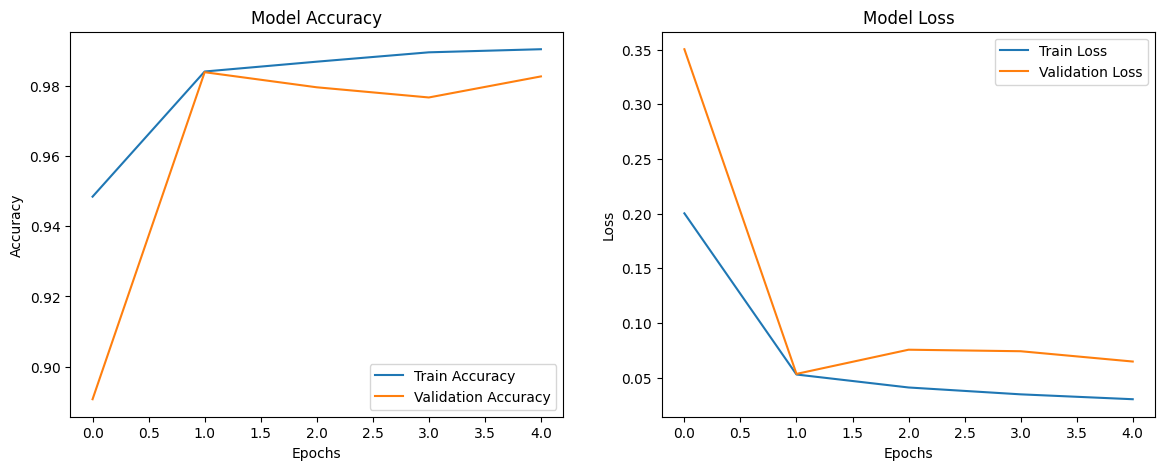

313/313 [==============================] - 3s 5ms/step


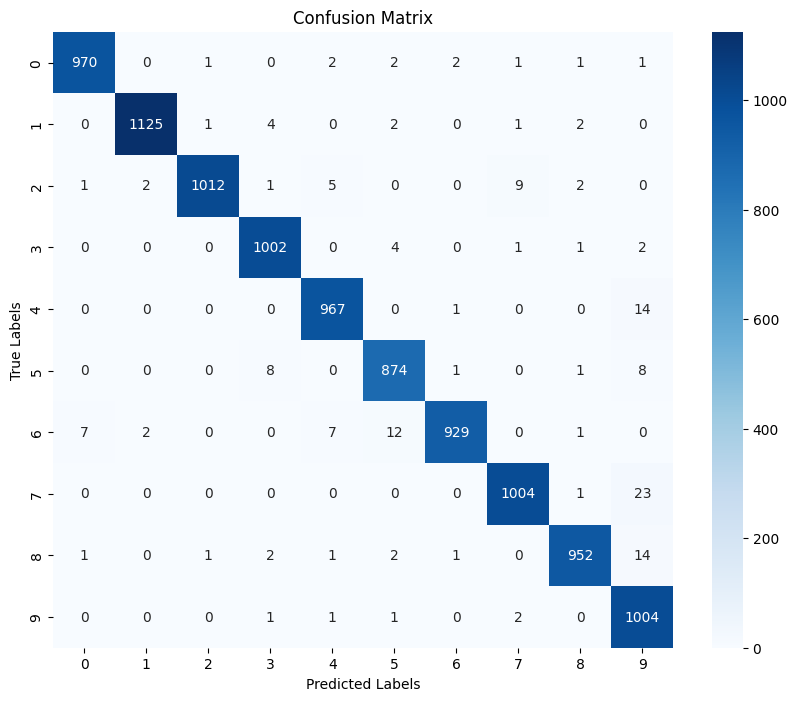

In [7]:
# Eğitim ve doğrulama doğruluğu ile kayıplarının saklanması
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Eğitim ve doğrulama sonuçlarının görselleştirilmesi
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

# Confusion matrix hesaplanması
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Confusion matrix görselleştirilmesi
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
